In [1]:
#%%
import os
import FinanceDataReader as fdr
from bt.algos import RunDaily
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.expected_returns import prices_from_returns
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quantstats as qs
import seaborn as sns
import sys

pd.options.display.float_format = '{:.4f}'.format
plt.style.use('default') #ggplot
plt.rcParams['font.family'] = 'nanummyeongjo'
plt.rcParams['figure.figsize'] = [12,8]
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = True

plt.rcParams['axes.formatter.useoffset'] = False
# plt.rcParmas['axes.formatter.limits'] = -1000, 1000

plt.rcParams['axes.unicode_minus'] = False

from IPython.display import display, HTML

# sys.path.insert(0, "/Users/hosung/workspace/git/bt/")
# for p in sys.path:
#     print(p)
%matplotlib inline

import bt
bt.__version__

(0, 2, 9)

In [2]:
def long_only_ew(data, tickers, start_date, name='long_only_ew', initial_capital=1000000.0):
    s = bt.Strategy(name,
    [
        bt.algos.RunAfterDate(start_date),
        bt.algos.RunOnce(),
        bt.algos.SelectThese(tickers),
        bt.algos.WeighEqually(),
        bt.algos.Rebalance()
    ])
    return bt.Backtest(s, data, initial_capital=initial_capital)

In [3]:
df = pd.read_csv('asset_db.csv', index_col=0, parse_dates=True)

In [4]:
cols = ['nasdaq100_UH', 'kbond20y', 'kodex200x2', 'usdkrwx2']
price_df = df[cols].copy()
#nasdaq100_UH 1985-10-02 00:00:00
#kbond20y 1981-05-01 00:00:00
#kodex200x2 1981-05-01 00:00:00
#usdkrwx2 1981-05-01 00:00:00


In [5]:
price_df['1985-10'].tail(2)

/var/folders/68/pm9snk_d53j26rdq0n4v_jn80000gn/T/ipykernel_81456/572385914.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  price_df['1985-10'].tail(2)


,nasdaq100_UH,kbond20y,kodex200x2,usdkrwx2
Date,,,,
1985-10-30,443.9889,819.4888,527.9910,4753.0506
1985-10-31,442.7283,821.6153,520.8193,4750.2029


In [6]:
price_df['1986-10'].tail(2)

/var/folders/68/pm9snk_d53j26rdq0n4v_jn80000gn/T/ipykernel_81456/779653957.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  price_df['1986-10'].tail(2)


,nasdaq100_UH,kbond20y,kodex200x2,usdkrwx2
Date,,,,
1986-10-30,544.2618,981.1386,1454.1757,4662.7489
1986-10-31,543.1959,979.4770,1457.7345,4664.1452


In [7]:
price_df.tail(2)

,nasdaq100_UH,kbond20y,kodex200x2,usdkrwx2
Date,,,,
2021-09-30,78930.0000,126480.0000,24560.0000,10105.0000
2021-10-01,77670.0000,125820.0000,23610.0000,10170.0000


In [8]:
start_date = '1986-10-30'
price_df = price_df.dropna()['1985-10-30':]

In [32]:
import pprint
from pypfopt import CLA
class WeighMaxSharpe(bt.Algo):
    """ PyPortfolioOpt 패키지를 사용하여 max sharpe로 비중을 계산"""
    def __init__(
        self,
        lookback=pd.DateOffset(months=3),
        bounds=(0.0, 1.0),
        covar_method="ledoit-wolf",
        lag=pd.DateOffset(days=1),
    ):
        super(WeighMaxSharpe, self).__init__()
        self.lookback = lookback
        self.bounds = bounds
        self.covar_method = covar_method
        self.lag = lag

    def __call__(self, target):
        selected = target.temp['selected']

        t0 = target.now - self.lag
        start = t0 - self.lookback
        prc = target.universe.loc[start:t0, selected]
        # print(prc)
        mu = expected_returns.mean_historical_return(prc)
        S = risk_models.sample_cov(prc, frequency=252)
        # S = risk_models.risk_matrix(prc, "ledoit_wolf", frequency=252)

        # Optimise for maximal Sharpe ratio
        # ef = EfficientFrontier(mu, S, weight_bounds=self.bounds)
        # raw_weights = ef.max_sharpe()
        # cleaned_weights = ef.clean_weights()
        # https://github.com/robertmartin8/PyPortfolioOpt/issues/88
        cla = CLA(mu, S, weight_bounds=self.bounds)
        cla.max_sharpe()
        cleaned_weights = cla.clean_weights()

        # print("\n======= Max Sharpe =======")
        # pprint.pprint(cleaned_weights)
        # print("=================================")

        target.temp['weights'] = pd.Series(cleaned_weights)
        return True

In [33]:
INIT_CAP = 100000000.0
def strategy_aibeta(price_df, lookback=3, max=0.5):
    st = bt.Strategy(f"AIBeta_{lookback}_{max:.2f}",
                    [
                        bt.algos.RunAfterDate(start_date),
                        bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=True),
                        # bt.algos.PrintDate(),
                        bt.algos.SelectAll(),
                        WeighMaxSharpe(lookback=pd.DateOffset(months=lookback), 
                                       lag = pd.DateOffset(days=1),
                                       bounds=(0.0, max), 
                                       covar_method='sample_cov'),
                        bt.algos.Rebalance()
                    ])
    bt_ai_beta = bt.Backtest(st, price_df, initial_capital=INIT_CAP)
    return bt_ai_beta

In [38]:
test_aibeta = {}
for lookback in range(3, 13):
    # print(f"lookback : {lookback}")
    for bound in np.arange(0.3, 0.5, 0.05):
        test_aibeta[f'AIBeta_{lookback}_{bound:.2f}'] = strategy_aibeta(price_df, lookback, bound)
# %%
rm = bt.run(*test_aibeta.values())

In [39]:
stats = rm.prices[start_date:].calc_stats().stats
stats

,AIBeta_3_0.30,AIBeta_3_0.35,AIBeta_3_0.40,AIBeta_3_0.45,AIBeta_4_0.30,AIBeta_4_0.35,AIBeta_4_0.40,AIBeta_4_0.45,AIBeta_5_0.30,AIBeta_5_0.35,...,AIBeta_10_0.40,AIBeta_10_0.45,AIBeta_11_0.30,AIBeta_11_0.35,AIBeta_11_0.40,AIBeta_11_0.45,AIBeta_12_0.30,AIBeta_12_0.35,AIBeta_12_0.40,AIBeta_12_0.45
start,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,...,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00
end,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,...,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00
rf,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
total_return,233.4309,350.3763,327.5585,298.2194,217.8155,311.0039,286.4003,283.0734,194.6775,284.5257,...,423.9666,376.0832,203.5599,396.5253,446.9683,467.1406,185.8201,333.1071,386.1920,379.5167
cagr,0.1691,0.1828,0.1805,0.1773,0.1668,0.1788,0.1760,0.1756,0.1631,0.1758,...,0.1892,0.1852,0.1646,0.1870,0.1910,0.1925,0.1616,0.1811,0.1861,0.1855
max_drawdown,-0.2842,-0.2981,-0.3054,-0.3143,-0.3259,-0.3502,-0.3404,-0.3217,-0.2955,-0.3084,...,-0.3295,-0.3479,-0.2842,-0.3085,-0.3295,-0.3479,-0.2842,-0.3085,-0.3295,-0.3479
calmar,0.5952,0.6132,0.5910,0.5642,0.5119,0.5104,0.5170,0.5458,0.5520,0.5699,...,0.5744,0.5322,0.5792,0.6060,0.5798,0.5534,0.5686,0.5869,0.5647,0.5331
mtd,-0.0083,-0.0060,-0.0061,-0.0059,-0.0083,-0.0073,-0.0072,-0.0070,-0.0083,-0.0068,...,-0.0099,-0.0091,-0.0138,-0.0134,-0.0119,-0.0107,-0.0150,-0.0149,-0.0134,-0.0120
three_month,-0.0030,-0.0019,0.0003,0.0020,-0.0012,0.0059,0.0108,0.0152,-0.0028,0.0013,...,-0.0169,-0.0183,-0.0293,-0.0318,-0.0312,-0.0336,-0.0200,-0.0219,-0.0279,-0.0286
six_month,0.0475,0.0522,0.0521,0.0508,0.0426,0.0500,0.0522,0.0543,0.0400,0.0434,...,0.0222,0.0196,0.0043,0.0008,0.0033,0.0027,0.0142,0.0125,0.0083,0.0098


In [35]:
# stats.to_csv('AIBeta_results_extend.csv')

In [40]:
stats = stats.loc[['total_return', 'cagr', 'max_drawdown', 'daily_sharpe'],:].T
stats.columns = ['return', 'cagr', 'mdd', 'sharpe']
stats['mdd'] = stats['mdd']*-1
stats.sort_values(by='return', ascending=False)

,return,cagr,mdd,sharpe
AIBeta_11_0.45,467.1406,0.1925,0.3479,1.0948
AIBeta_11_0.40,446.9683,0.1910,0.3295,1.1229
AIBeta_6_0.45,428.7415,0.1896,0.3480,1.0728
AIBeta_10_0.40,423.9666,0.1892,0.3295,1.1148
AIBeta_10_0.35,420.3003,0.1889,0.3085,1.1380
AIBeta_6_0.40,410.0151,0.1881,0.3295,1.0996
AIBeta_6_0.35,405.8466,0.1877,0.3085,1.1246
AIBeta_11_0.35,396.5253,0.1870,0.3085,1.1241
AIBeta_7_0.35,389.3072,0.1863,0.3085,1.1221
AIBeta_12_0.40,386.1920,0.1861,0.3295,1.0990


<AxesSubplot:>

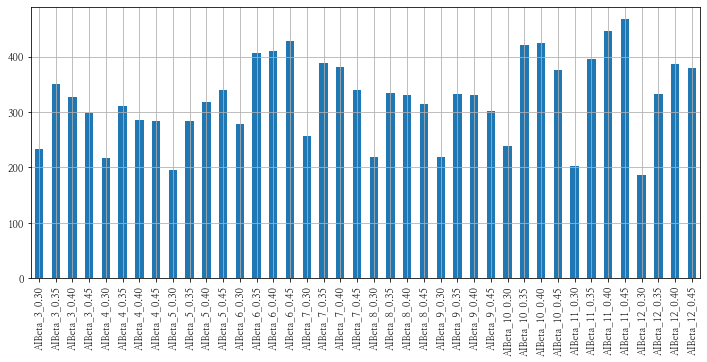

In [41]:
stats['return'].plot.bar(figsize=(12, 5))#, secondary_y=['mdd'])

<AxesSubplot:>

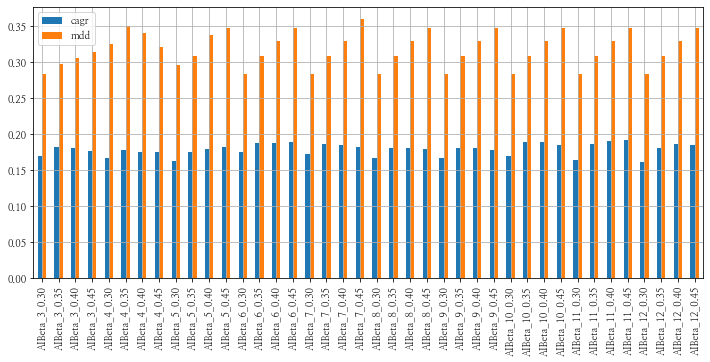

In [59]:
stats[['cagr', 'mdd']].plot.bar(figsize=(12, 5))#

<AxesSubplot:>

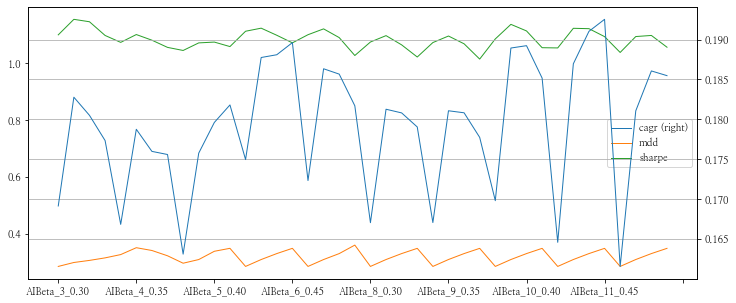

In [42]:
stats[['cagr', 'mdd', 'sharpe']].plot(figsize=(12,5), secondary_y=['cagr'])

In [43]:
bt_ew = long_only_ew(price_df, cols, start_date, "ew")

bt_kodex200x2 = long_only_ew(price_df, ["kodex200x2"], start_date, "kodex200x2")
bt_kbond20y = long_only_ew(price_df, ["kbond20y"], start_date, "kbond20y")
bt_nasdaq100_UH = long_only_ew(price_df, ["nasdaq100_UH"], start_date, "nasdaq100_UH")
bt_usdkrwx2 = long_only_ew(price_df, ["usdkrwx2"], start_date, "usdkrwx2")

bt_ai_beta_3_35 = strategy_aibeta(price_df, 3, 0.35)
bt_ai_beta_11_45 = strategy_aibeta(price_df, 11, 0.45)

In [44]:
r = bt.run(bt_ai_beta_3_35, bt_ai_beta_11_45, bt_kodex200x2, bt_kbond20y, bt_nasdaq100_UH, bt_usdkrwx2)

In [45]:
r.set_date_range(start=start_date)
r.display()

Stat                 AIBeta_3_0.35    AIBeta_11_0.45    kodex200x2    kbond20y    nasdaq100_UH    usdkrwx2
-------------------  ---------------  ----------------  ------------  ----------  --------------  ----------
Start                1986-10-30       1986-10-30        1986-10-30    1986-10-30  1986-10-30      1986-10-30
End                  2021-10-01       2021-10-01        2021-10-01    2021-10-01  2021-10-01      2021-10-01
Risk-free rate       0.00%            0.00%             0.00%         0.00%       0.00%           0.00%

Total Return         35037.63%        46643.86%         1517.43%      12733.73%   14191.33%       117.83%
Daily Sharpe         1.16             1.09              0.40          1.24        0.64            0.21
Daily Sortino        1.87             1.75              0.66          1.87        1.05            0.33
CAGR                 18.28%           19.25%            8.30%         14.91%      15.27%          2.25%
Max Drawdown         -29.81%          -34.79%

/Users/hosung/miniconda3/envs/py38/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1389: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)


<AxesSubplot:>

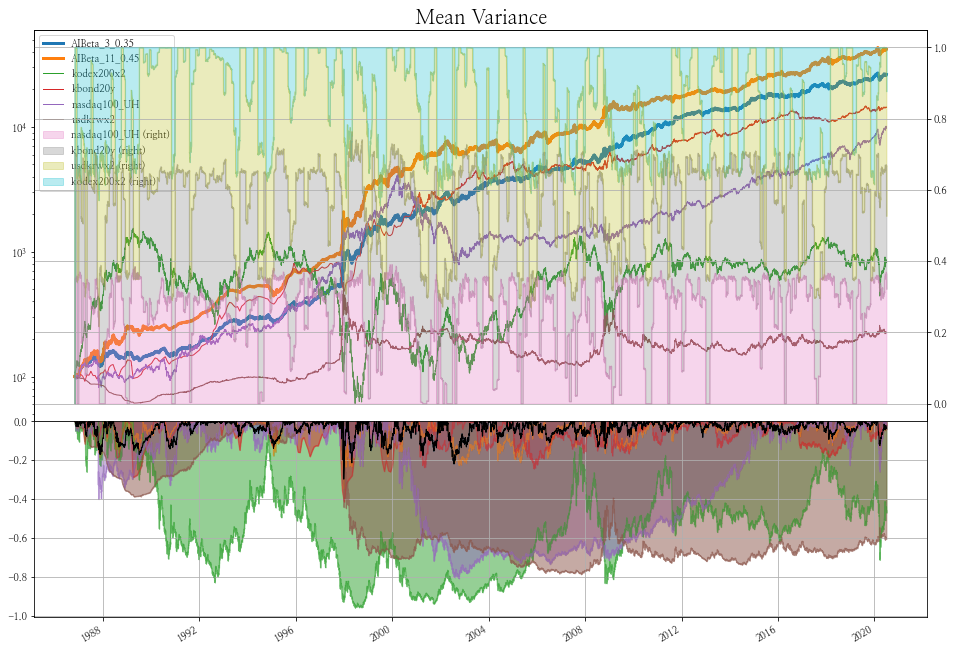

In [47]:
res1 = r
start = start_date
end = '2020-06-30'
plt.rcParams["figure.figsize"] = [16, 12]
plt.subplots_adjust(hspace=0)

# 첫번째 칸에 그림을 그린다.
ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2)
# 두개를 한 칸에 그리기 위해 ax=ax1으로 axis공유
ax2 = res1.prices[start:end].plot(ax=ax1, style=['-', '-', '-', '-', '-', '-', '-'], lw=1, logy=True) # 모든 데이터 r_all
for line in ax2.get_lines():
    if line.get_label() == 'AIBeta_3_0.35' or line.get_label() == 'AIBeta_11_0.45' or line.get_label() == 'AIBet_InvVol':
        line.set_linewidth(3)
plt.legend(loc="upper left");
plt.title('Mean Variance', fontsize=20)
res1.get_security_weights('AIBeta_3_0.35')[start:end].plot.area(alpha=0.3, ax=ax1, secondary_y=True)


# 두번째 칸에 그림을 그린다.
# drawdown을 그림다. 두개를 하나에 그리기 위해 ax=ax2로 axis를 공유
ax2 = plt.subplot2grid((3,1), (2,0))
res1.prices[start:end].to_drawdown_series().plot.area(stacked=False,legend=False, ax=ax2)
res1.prices.loc[start:end,'AIBeta_3_0.35'].to_drawdown_series().plot(legend=False, color='black', alpha=1, lw=1, ls='-', ax=ax2)


In [48]:
r.display_monthly_returns('AIBeta_3_0.35')

  Year    Jan    Feb     Mar    Apr    May    Jun    Jul    Aug    Sep    Oct    Nov    Dec     YTD
------  -----  -----  ------  -----  -----  -----  -----  -----  -----  -----  -----  -----  ------
  1986   0      0       0      0      0      0      0      0      0      0     -1.03   2.19    1.14
  1987  16.43   4.14    8.07  -6.29   5.55   6.3   -0.21  -0.14  -1.6   -5.71  -3.26   6.37   31.09
  1988  14.37  -4.74    9.05   0.49   0.96  -2.63  -2.77  -7.51   2.41  -1.3    0.57   7.92   15.79
  1989  -1.17   1.49   -6.76  -2.38   1.96  -6.41   2.73   4.31   1.36   0.94   1.58   0.67   -2.33
  1990   1.57   3.06    0.94  -2.17   5.24   2.25  -1.07  -6.77  -4.21   0.83   1.09   1       1.19
  1991   4.29   3.7     1.65   0.83   0.98  -1.62   2.4   -2.16   1.7    2.68   0.47   4.25   20.67
  1992   5.47   2.25   -0.39   0.38   1.75   1.55   5.85   0.73   4.94   6.9    0.42   3.25   38.21
  1993   3.76   2.31    3.71  -0.58   1.73  -1.04  -2.45  -3.01   4.06   1.4    1.52   3.15   15.19


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               1986-10-31  1986-10-31
End Period                 2021-10-01  2021-10-01
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          35,037.63%  46,643.86%
CAGR﹪                     18.26%      19.23%

Sharpe                     1.16        1.09
Smart Sharpe               1.09        1.03
Sortino                    1.72        1.64
Smart Sortino              1.61        1.54
Sortino/√2                 1.21        1.16
Smart Sortino/√2           1.14        1.09
Omega                      1.27        1.27

Max Drawdown               -29.81%     -34.79%
Longest DD Days            716         718
Volatility (ann.)          14.89%      16.7%
R^2                        0.69        0.69
Calmar                     0.61        0.55
Skew                       -0.57       0.11
Kurtosis                   61.77     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,1997-12-24,1997-12-26,1998-02-18,56,-29.8054,-29.7656
2,2002-04-19,2002-07-23,2003-05-28,404,-21.9643,-20.5448
3,1998-03-02,1998-04-28,1998-07-20,140,-21.3971,-19.8429
4,1997-12-12,1997-12-16,1997-12-23,11,-19.8839,-16.1735
5,2001-01-26,2001-04-10,2001-11-26,304,-17.6144,-16.2347


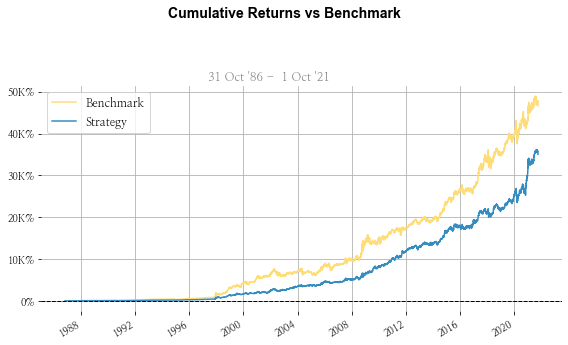

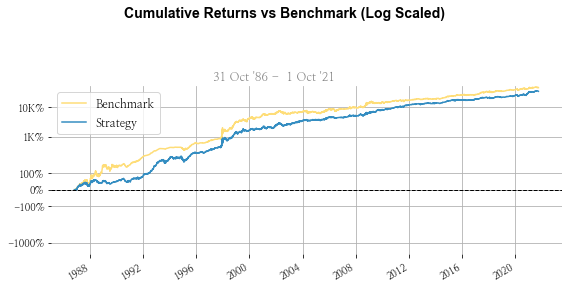

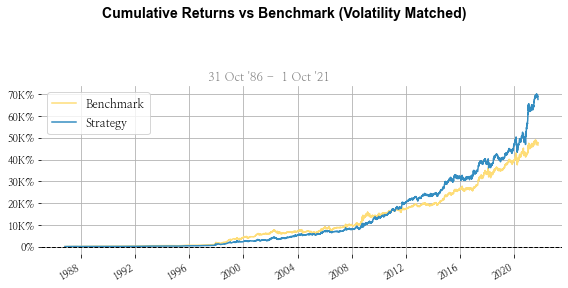

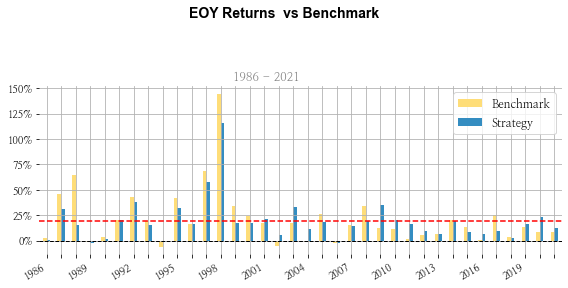

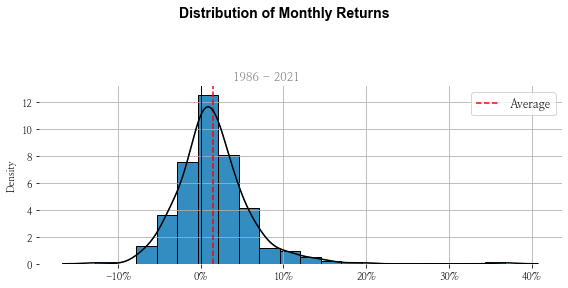

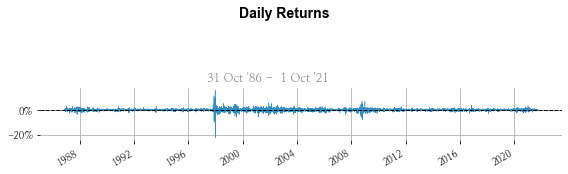

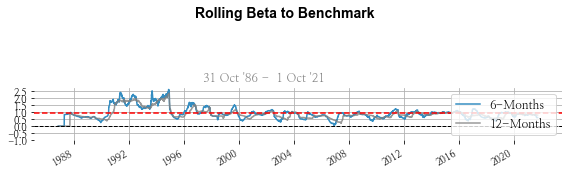

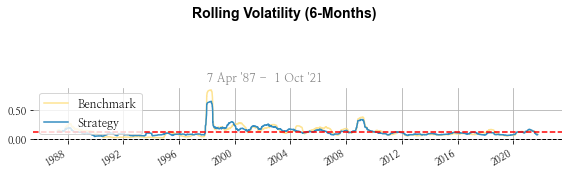

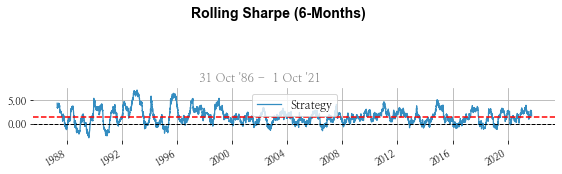

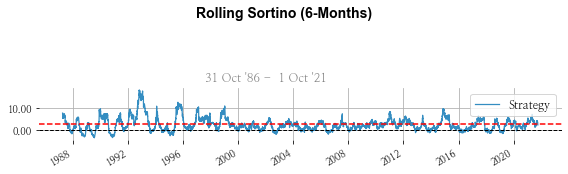

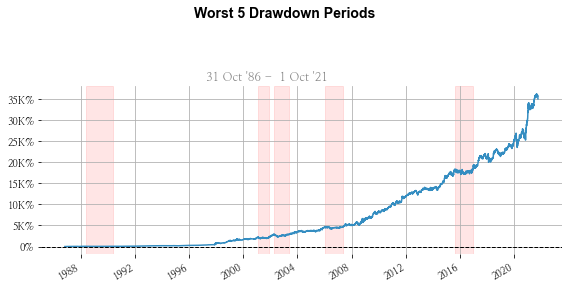

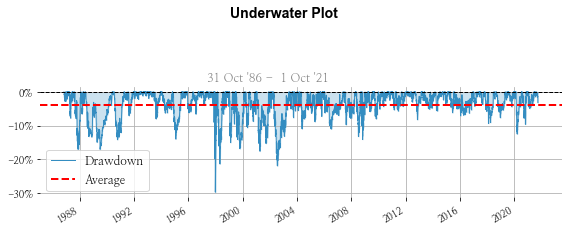

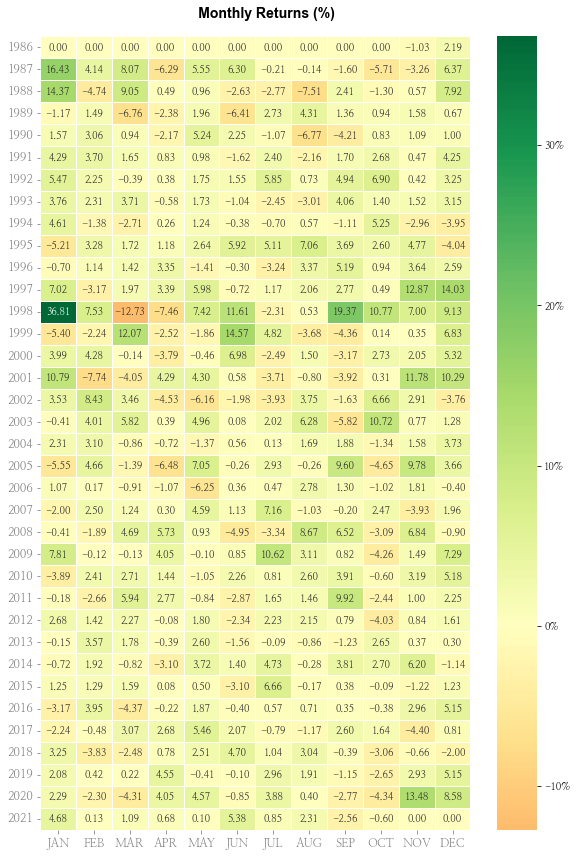

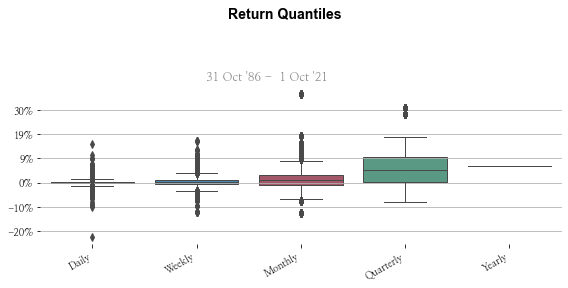

In [49]:
qs.reports.full(r.prices['AIBeta_3_0.35'].to_returns().dropna(), r.prices['AIBeta_11_0.45'].to_returns().dropna())

In [50]:
r.prices.calc_cagr()

AIBeta_3_0.35    0.1828
AIBeta_11_0.45   0.1925
kodex200x2       0.0830
kbond20y         0.1491
nasdaq100_UH     0.1527
usdkrwx2         0.0225
dtype: float64

2021-10-01 00:00:00


<AxesSubplot:>

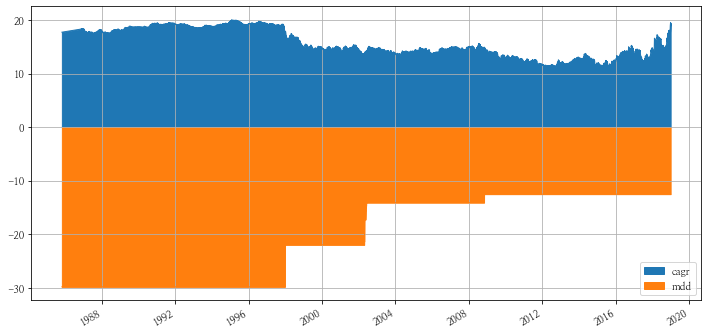

In [52]:
r_ai = bt.run(bt_ai_beta_3_35)
cagrs = {}
mdds = {}
# for m in pd.date_range(start_date, '2021-10', freq='M'):
for m in r_ai.prices.index:
    # print(m)
    try:
        cagrs[m] = r_ai.prices[m:].calc_cagr().values[0]
        mdds[m] = r_ai.prices[m:].calc_max_drawdown().values[0]
    except:
        print(m)

cagr_df = pd.DataFrame([cagrs]).T*100
mdd_df = pd.DataFrame([mdds]).T*100

tdf = bt.merge(cagr_df, mdd_df)
tdf.columns = ['cagr', 'mdd']

tdf[:'2018'].plot.area(figsize=(12,6))

In [47]:
# tdf.to_csv("AIBeta_3개월_0.35_CAGR_MDD.csv")

2021-10-01 00:00:00


<AxesSubplot:>

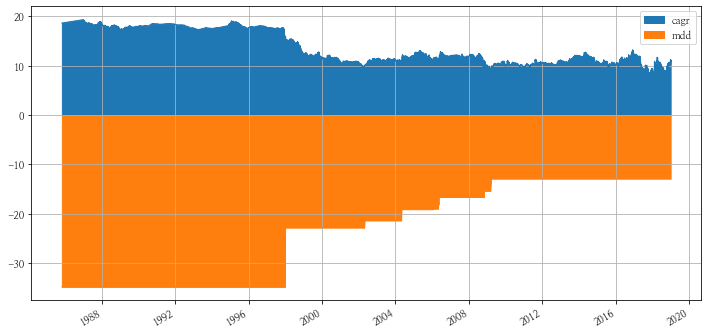

In [53]:
r_ai = bt.run(bt_ai_beta_11_45)
cagrs = {}
mdds = {}
# for m in pd.date_range(start_date, '2021-10', freq='M'):
for m in r_ai.prices.index:
    # print(m)
    try:
        cagrs[m] = r_ai.prices[m:].calc_cagr().values[0]
        mdds[m] = r_ai.prices[m:].calc_max_drawdown().values[0]
    except:
        print(m)

cagr_df = pd.DataFrame([cagrs]).T*100
mdd_df = pd.DataFrame([mdds]).T*100

tdf = bt.merge(cagr_df, mdd_df)
tdf.columns = ['cagr', 'mdd']

tdf[:'2018'].plot.area(figsize=(12,6))

In [49]:
# tdf.to_csv("AIBeta_3개월_0.50_CAGR_MDD.csv")

(0.0, 1.0)

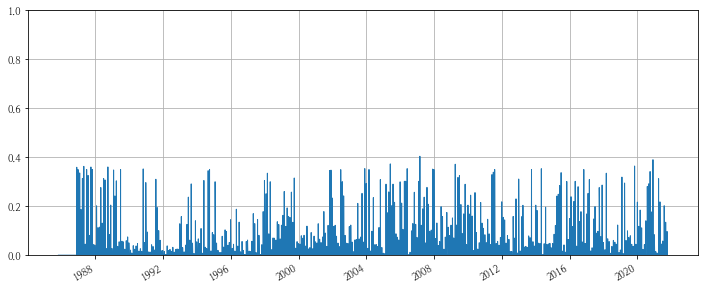

In [54]:
ax = bt_ai_beta_3_35.turnover.plot(figsize=(12,5))
ax.set_ylim(0.0, 1.0)

(0.0, 1.0)

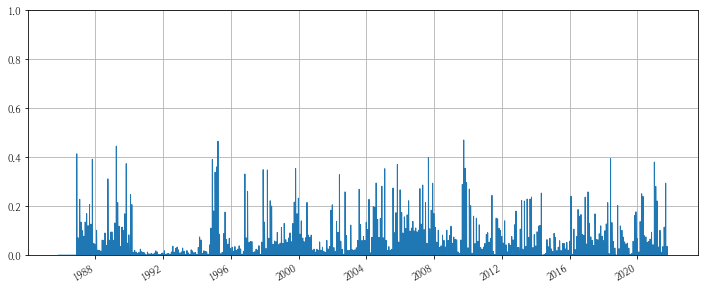

In [56]:
ax = bt_ai_beta_11_45.turnover.plot(figsize=(12,5))
ax.set_ylim(0.0, 1.0)